In [1]:
from __future__ import division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set_style('darkgrid')

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


1. Preparing data

In [2]:
data = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

print('Number of features: %s' %data.shape[1])
print('Number of examples: %s' %data.shape[0])

Number of features: 16
Number of examples: 48895


In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# I want to describe only columns which contain numerical values

data.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review'], axis=1).describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
# Printing unique values for string columns

for col in data[['neighbourhood_group', 'neighbourhood', 'room_type']]:
    print('Unique values in column: %s' %col)
    print(data[col].unique()), '\n'

Unique values in column: neighbourhood_group
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique values in column: neighbourhood
['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason 

2. Null values

In [6]:
print('Null values in Airbnb dataset: \n')
print(data.isnull().sum())
print('\n')
print('Percentage of null values in review columns: ')
print(round(data['last_review'].isnull().sum()/len(data)*100, 2),"%")

# For reviews there are many null values so i want to also see percentage to the whole dataset
# Null values in name, host_name, last_review, reviews_per_month, which for reviews is the same amount. 
# I want to see if it is for the same rows
# I want to see also how null values for name and host_name are distributed because these amounts are different

Null values in Airbnb dataset: 

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


Percentage of null values in review columns: 
20.56 %


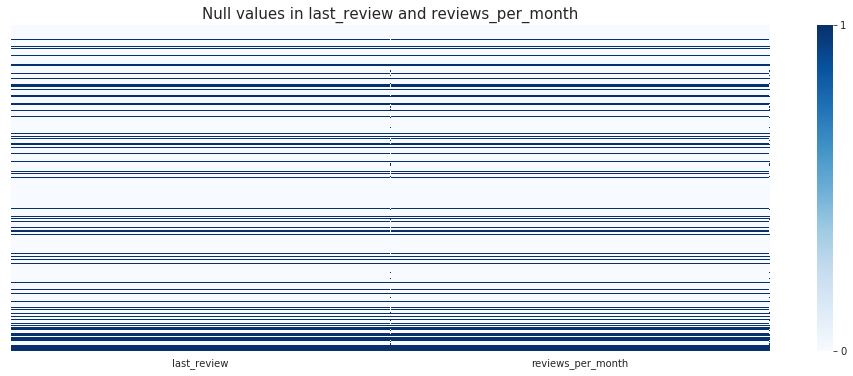

In [7]:
fig, ax = plt.subplots(figsize=(17,6))
plt.title('Null values in last_review and reviews_per_month', fontsize=15)
sns.heatmap(data[['last_review','reviews_per_month' ]].isnull(), cmap="Blues", yticklabels=False, ax=ax, cbar_kws={'ticks': [0, 1]})

In [8]:
null_name = (pd.DataFrame(np.where((data['name'].isnull())))).transpose()
null_host_name = (pd.DataFrame(np.where((data['host_name'].isnull())))).transpose()

sum_null = pd.concat([null_name,null_host_name], axis=1, ignore_index=True)
sum_null.columns = ['Null rows in name', 'Null rows in host_name']
sum_null

# Null values in name and host_name columns are accidental

,Null rows in name,Null rows in host_name
0,2854.0,360
1,3703.0,2700
2,5775.0,5745
3,5975.0,6075
4,6269.0,6582
5,6567.0,8163
6,6605.0,8257
7,8841.0,8852
8,11963.0,9138
9,12824.0,9817


In [9]:
# last_review column may be dropped

data.drop('last_review', axis=1, inplace=True)

In [10]:
# Null values for name and host_name I replace with 0. Also reviews_per_month I replace with 0

data['name'].fillna(value=0, inplace=True)

In [11]:
data['host_name'].fillna(value=0, inplace=True)

In [12]:
data['reviews_per_month'].fillna(value=0, inplace=True)

In [13]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [14]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


3. Evaluations

In [15]:
# Evaluation 1 - top 3 hosts; hosts with the biggest amount of listings

top_3_hosts = (pd.DataFrame(data.host_id.value_counts())).head(3)
top_3_hosts.columns=['Listings']
top_3_hosts['host_id'] = top_3_hosts.index
top_3_hosts.reset_index(drop=True, inplace=True)
top_3_hosts

,Listings,host_id
0,327,219517861
1,232,107434423
2,121,30283594


In [16]:
# Evaluation 2 - top 3 the hottest neighbourhoood groups

top_3_neigh = pd.DataFrame(data['neighbourhood_group'].value_counts().head(3))
top_3_neigh.columns=['Listings']
top_3_neigh['Neighbourhood Group'] = top_3_neigh.index
top_3_neigh.reset_index(drop=True, inplace=True)
top_3_neigh

,Listings,Neighbourhood Group
0,21661,Manhattan
1,20104,Brooklyn
2,5666,Queens


In [17]:
# Evaluation 3 - average price, availability in year 

average_price_ava = pd.DataFrame(data[['price', 'availability_365']].describe())
average_price_ava.columns=['Price', 'Availability in a year']
average_price_ava

,Price,Availability in a year
count,48895.000000,48895.000000
mean,152.720687,112.781327
std,240.154170,131.622289
min,0.000000,0.000000
25%,69.000000,0.000000
50%,106.000000,45.000000
75%,175.000000,227.000000
max,10000.000000,365.000000


In [18]:
# Evaluation 4 - most reviewed hosts

rev_group = pd.DataFrame(data.groupby('number_of_reviews').sum()['host_id'])
most_reviewed = (rev_group.sort_values('number_of_reviews',ascending=False)).head(3)
most_reviewed.columns = ['Host ID']
most_reviewed['Number of reviews'] = most_reviewed.index
most_reviewed.reset_index(drop=True, inplace=True)
most_reviewed

,Host ID,Number of reviews
0,47621202,629
1,4734398,607
2,4734398,597


In [19]:
# Evaluation 5 - the most reviewed hosts per month

gr = pd.DataFrame(data.groupby('reviews_per_month').sum()['host_id'])
rev = (gr.sort_values('reviews_per_month',ascending=False)).head(3)
rev.columns = ['Host ID']
rev['Reviews per month'] = rev.index
rev.reset_index(drop=True, inplace=True)
rev

,Host ID,Reviews per month
0,244361589,58.50
1,244361589,27.95
2,228415932,20.94


In [20]:

# Evaluation 6 - prices in every neighbourhood group

# Brooklyn
nei1 = data.loc[data['neighbourhood_group'] == 'Brooklyn']
price_nei1 = nei1[['price']]
# Manhattan
nei2 = data.loc[data['neighbourhood_group'] == 'Manhattan']
price_nei2 = nei2[['price']]
# Queens
nei3 = data.loc[data['neighbourhood_group'] == 'Queens']
price_nei3 = nei3[['price']]
# Staten Island
nei4 = data.loc[data['neighbourhood_group'] == 'Staten Island']
price_nei4 = nei4[['price']]
# Bronx
nei5 = data.loc[data['neighbourhood_group'] == 'Bronx']
price_nei5 = nei5[['price']]

price_list = [price_nei1, price_nei2, price_nei3, price_nei4, price_nei5]



price_stats = []
nei_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

# price statistics for every neighbourhood

for x in price_list:
    i = x.describe(percentiles=[.25, .5, .75])
    i = i.iloc[3:]
    i.reset_index(inplace=True)
    i.rename(columns={'index': 'Stats'}, inplace=True)
    price_stats.append(i)

price_stats[0].rename(columns={'price': nei_list[0]}, inplace=True)
price_stats[1].rename(columns={'price': nei_list[1]}, inplace=True)
price_stats[2].rename(columns={'price': nei_list[2]}, inplace=True)
price_stats[3].rename(columns={'price': nei_list[3]}, inplace=True)
price_stats[4].rename(columns={'price': nei_list[4]}, inplace=True)

# final view of dataframe

stats_df = price_stats
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df=stats_df[0].join(stats_df[1:])
stats_df

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
min,0.0,0.0,10.0,13.0,0.0
25%,60.0,95.0,50.0,50.0,45.0
50%,90.0,150.0,75.0,75.0,65.0
75%,150.0,220.0,110.0,110.0,99.0
max,10000.0,10000.0,10000.0,5000.0,2500.0


4. Visualisations

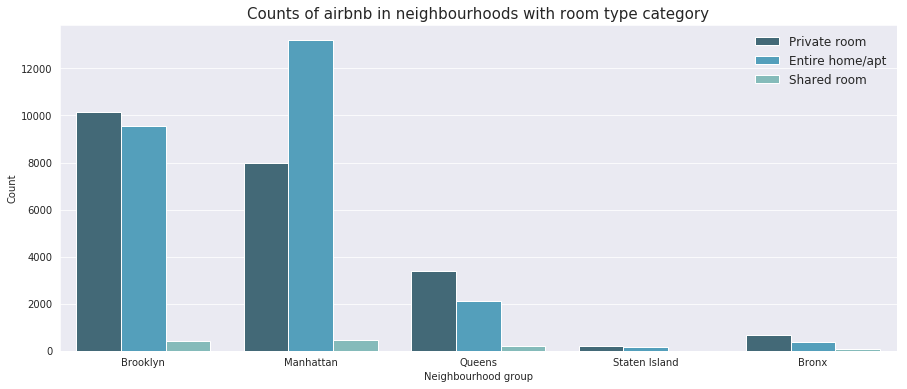

In [21]:
# Visualisation 1 - Neighbourhood groups with counts with category room_type

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='neighbourhood_group', hue='room_type', palette='GnBu_d')
plt.title('Counts of airbnb in neighbourhoods with room type category', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Count")
plt.legend(frameon=False, fontsize=12)

Text(0, 0.5, 'Price')

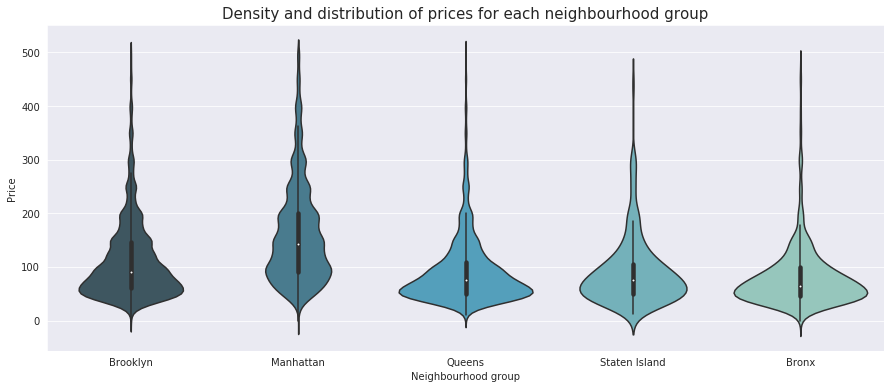

In [22]:
# Visualisation 2 - distribution of prices

plt.figure(figsize=(15,6))
sns.violinplot(data=data[data.price <500], x='neighbourhood_group', y='price', palette='GnBu_d')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

<Figure size 1080x432 with 0 Axes>

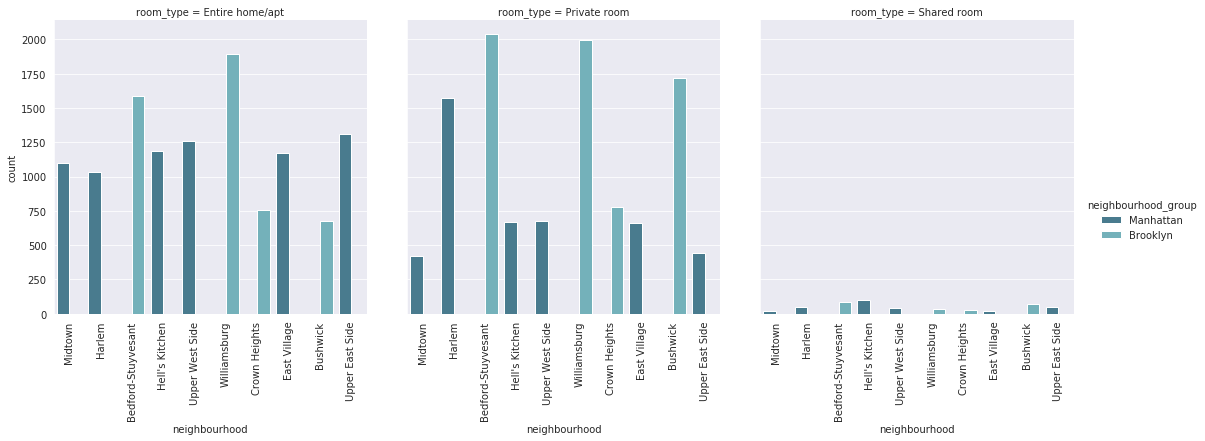

In [23]:
# Visualisation 3 - top neighbourhoods with category of room type

top_nei = data['neighbourhood'].value_counts().reset_index().head(10)
top_nei = top_nei['index'].tolist()

plt.figure(figsize=(15,6))
vis_3 = sns.catplot(x='neighbourhood', hue='neighbourhood_group', col='room_type', data=data.loc[data['neighbourhood'].isin(top_nei)], kind='count', palette='GnBu_d')
vis_3.set_xticklabels(rotation=90)

Text(0, 0.5, 'Count')

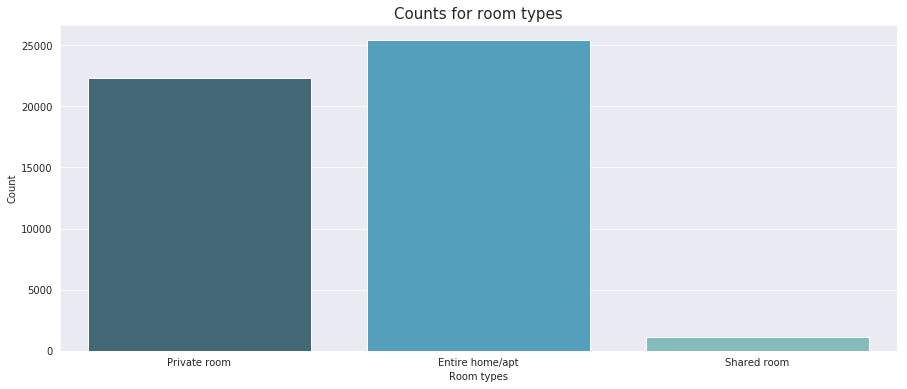

In [24]:
# Visualisation 4 - room types

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='room_type', palette='GnBu_d')
plt.title('Counts for room types', fontsize=15)
plt.xlabel('Room types')
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

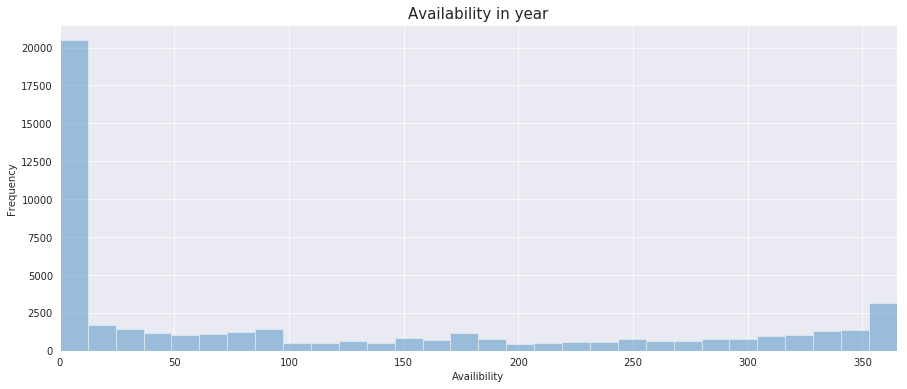

In [25]:
# Visualisation 5 - availability in year

plt.figure(figsize=(15,6))
sns.distplot(data.availability_365, kde=False)
plt.xlim(0,365)
plt.title('Availability in year', fontsize=15)
plt.xlabel('Availibility')
plt.ylabel("Frequency")

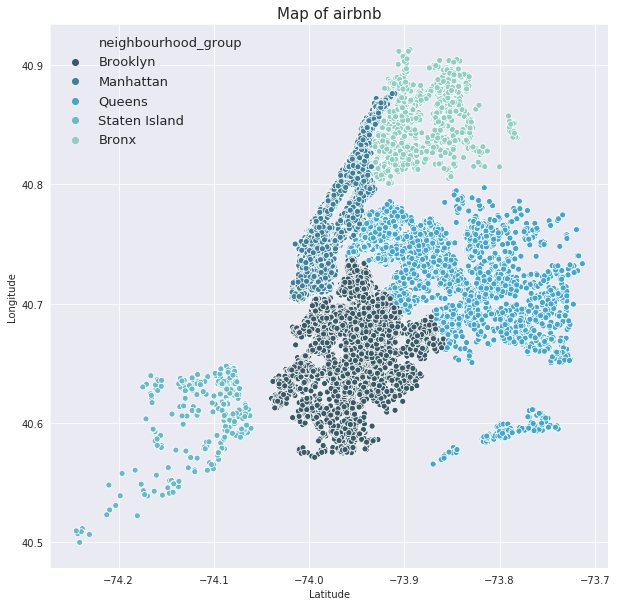

In [26]:
# Visualisation 6 - map of hosts

plt.figure(figsize=(10,10))
a = sns.scatterplot(data=data, x='longitude', y='latitude', hue='neighbourhood_group', palette='GnBu_d')
plt.title('Map of airbnb', fontsize=15)
plt.xlabel('Latitude')
plt.ylabel("Longitude")
plt.legend(frameon=False, fontsize=13)

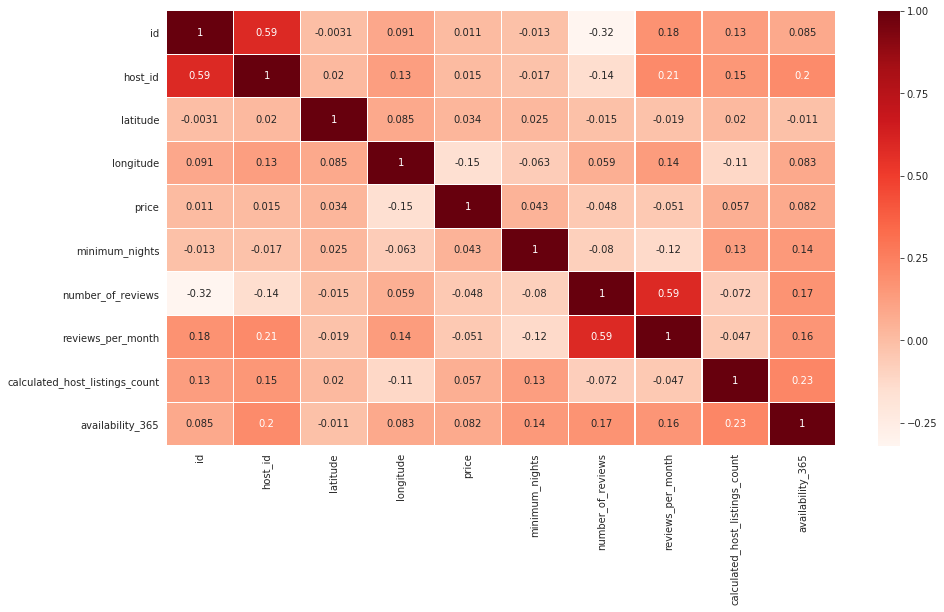

In [27]:
# Visualisation 7 - correlations between values

plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, linewidths=0.1, cmap='Reds')

In [28]:
# Visualisation 8 - prices in neighbourhoods 

data1 = pd.DataFrame(data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean())
data1.reset_index(inplace=True)

bronx = (data1[data1['neighbourhood_group'] =='Bronx']).sort_values(by='price',ascending=False).head(10)
brooklyn = (data1[data1['neighbourhood_group'] =='Brooklyn']).sort_values(by='price',ascending=False).head(10)
manhattan = (data1[data1['neighbourhood_group'] =='Manhattan']).sort_values(by='price',ascending=False).head(10)
queens = (data1[data1['neighbourhood_group'] =='Queens']).sort_values(by='price',ascending=False).head(10)
staten = (data1[data1['neighbourhood_group'] =='Staten Island']).sort_values(by='price',ascending=False).head(10)

neighs = [bronx, brooklyn, manhattan, queens, staten]
titles = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

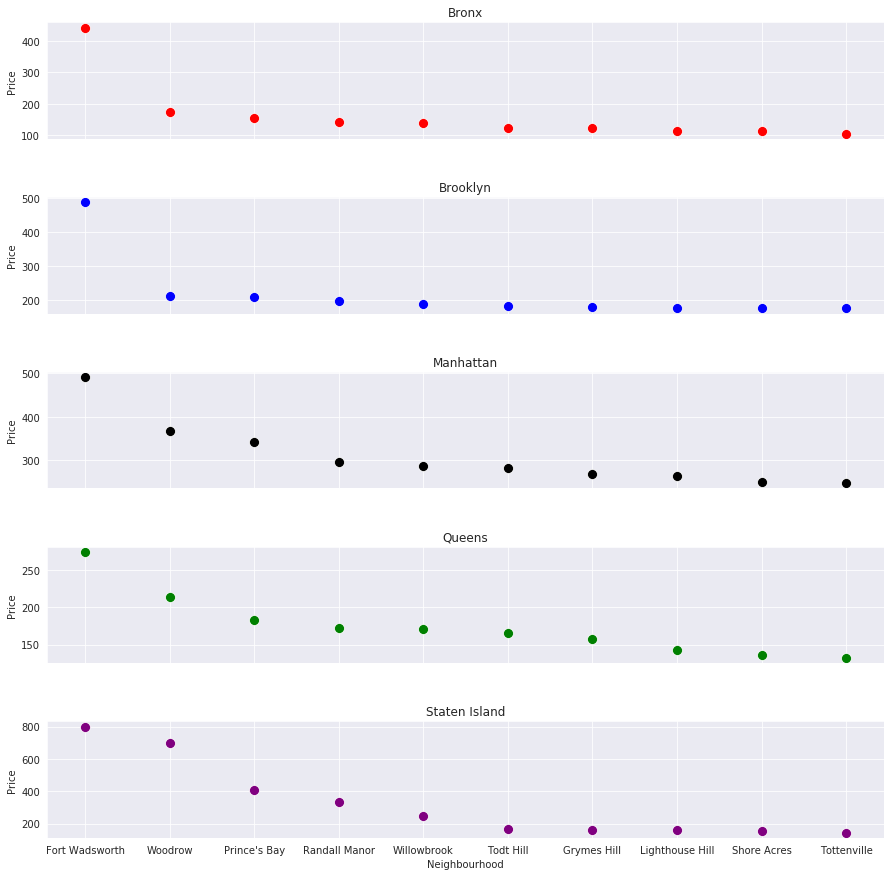

In [29]:
fig, axs = plt.subplots(5, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0})
sns.scatterplot(data=bronx, x='neighbourhood', y='price', ax=axs[0], color='red', s=100)
sns.scatterplot(data=brooklyn, x='neighbourhood', y='price', ax=axs[1], color='blue', s=100)
sns.scatterplot(data=manhattan, x='neighbourhood', y='price', ax=axs[2], color='black', s=100)
sns.scatterplot(data=queens, x='neighbourhood', y='price', ax=axs[3], color='green', s=100)
sns.scatterplot(data=staten, x='neighbourhood', y='price', ax=axs[4], color='purple', s=100)

axs[0].set_title('Bronx')
axs[1].set_title('Brooklyn')
axs[2].set_title('Manhattan')
axs[3].set_title('Queens')
axs[4].set_title('Staten Island')

for ax in axs:
    ax.set(xlabel='Neighbourhood', ylabel='Price')
    ax.label_outer()

5. Predictions

In [30]:
# Preparing dataset for predictions

data_pred = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

In [31]:
data_pred.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [32]:
data_pred.drop(['name', 'host_name', 'last_review', 'id'], inplace=True, axis=1)

In [33]:
data_pred['reviews_per_month'] = data_pred['reviews_per_month'].fillna(value=0, inplace=False)

In [34]:
data_pred.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [35]:
le = preprocessing.LabelEncoder()

le.fit(data_pred['neighbourhood_group'])
data_pred['neighbourhood_group']=le.transform(data_pred['neighbourhood_group'])

le.fit(data_pred['neighbourhood'])
data_pred['neighbourhood']=le.transform(data_pred['neighbourhood'])

le.fit(data_pred['room_type'])
data_pred['room_type']=le.transform(data_pred['room_type'])

In [36]:
data_pred.sort_values('price', ascending=True, inplace=True)

In [37]:
data_pred = data_pred[11:-6]

In [38]:
lm = LinearRegression()

In [39]:
X = data_pred.drop(['price', 'longitude'], inplace=False, axis=1)
y = data_pred['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
predictions = lm.predict(X_test)

In [41]:
# Evaluated metrics

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
r2 = metrics.r2_score(y_test, predictions)

print('MAE (Mean Absolute Error): %s' %mae)
print('MSE (Mean Squared Error): %s' %mse)
print('RMSE (Root mean squared error): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean Absolute Error): 76.12984118966268
MSE (Mean Squared Error): 42229.03230108089
RMSE (Root mean squared error): 205.49703720754928
R2 score: 0.09138535240632684


In [42]:
# Avtual vs predicted values

error = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': predictions.flatten()})
error.head(10)

,Actual Values,Predicted Values
0,85,127.025785
1,90,189.666365
2,50,72.411203
3,65,96.489395
4,450,157.853679
5,74,62.167818
6,80,116.745626
7,125,82.619808
8,72,111.386136
9,35,83.899589


Text(0, 0.5, 'Test')

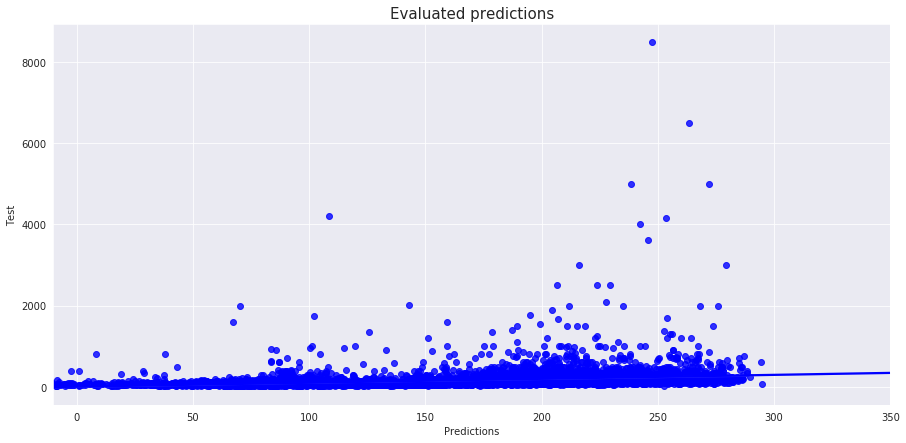

In [43]:
# Evaluated predictions

plt.figure(figsize=(15,7))
plt.xlim(-10,350)
sns.regplot(y=y_test, x=predictions, color='blue')
plt.title('Evaluated predictions', fontsize=15)
plt.xlabel('Predictions')
plt.ylabel('Test')